In [1]:
import numpy as np
import pickle
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from housing_elements import utils, final_results

# Load sites and permits DataFrames for each city

In [2]:
sites_df = utils.load_all_sites()

In [3]:
# cities_with_sites, cities_with_permits = final_results.load_sites_and_permits()

In [4]:
with open('cities_with_sites_cache.pkl', 'rb') as f:
    cities_with_sites = pickle.load(f)

with open('cities_with_permits_cache.pkl', 'rb') as f:
    cities_with_permits = pickle.load(f)

## Data Cleaning Factoids

### Realistic Capacity

#### Pre-Existing Nulls

Two ways to calculate NA realistic capacities come to the same conclusion

In [5]:
rhna5 = sites_df[sites_df.rhnacyc == 'RHNA5']

In [6]:
rhna5.relcapcty[rhna5.relcapcty.isna()].shape

(2910,)

In [7]:
rhna5[(rhna5.relcapcty.str.contains("/^([^0-9]*)$/") != False)].shape

/Users/sidharthkapur/Library/Caches/pypoetry/virtualenvs/housing-elements-H302xxA9-py3.8/lib/python3.8/site-packages/pandas/core/strings/accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


(2910, 35)

In [8]:
rhna5.shape

(20849, 35)

In [9]:
2910 / rhna5.shape[0]

0.13957503957024317

### Proportion of nulls that are our fault versus theirs

In [10]:
for city, site in cities_with_sites.items():
    num_fail_parse_realcap = site.realcap_parse_fail.sum()
    if num_fail_parse_realcap:
        print(city, end='\t')
        print('Realcap', num_fail_parse_realcap)

In [11]:
sum([site.realcap_parse_fail.sum() for city, site in cities_with_sites.items()])

0

None of the realistic capacity nulls are our fault.

#### Degenerate Rows

In [12]:
no_realcap = pd.to_numeric(rhna5.relcapcty, errors='coerce') == 0
no_locacreage = pd.to_numeric(rhna5.locacres, errors='coerce') == 0
no_gacreage = pd.to_numeric(rhna5.gacres, errors='coerce') == 0

In [13]:
rhna5[no_realcap & no_locacreage].shape

(14, 35)

In [14]:
rhna5[no_gacreage & no_locacreage].shape

(0, 35)

In [15]:
rhna5[no_gacreage].shape

(0, 35)

I wouldn't say there are any degenerate rows. Even when locacreage is zero, we can rely on gacreage instead. 

There are, however, 901 sites with no realistic capacity and no allowable density. What kind of sites are these?

They're mostly in San Francisco and have a zoning type of PDR. According to SF's website, "In order to protect PDR, residential development would be prohibited, while office, retail, and institutional uses (schools, hospitals, etc.) would be limited. HOWEVER, residences, offices and retail which currently exist legally in these areas may stay indefinitely."


In [16]:
sf_sites = cities_with_sites['San Francisco']
sf_sites_fixed = sf_sites[
    sf_sites['relcapcty'] != 0
]
cities_with_sites['San Francisco'] = sf_sites_fixed

In [17]:
sf_sites.shape

(5254, 30)

## Results

In [18]:
apn_results_df = pd.read_csv('results/apn_matching_results.csv')

Text(0.5, 1.0, 'Are missing APNs skewing our results?')

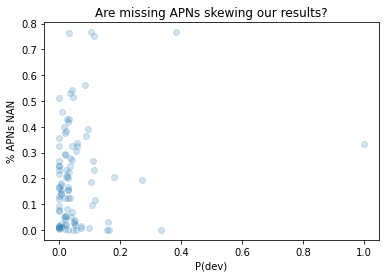

In [19]:
x = apn_results_df["P(dev) for inventory"]
y = [utils.fraction_apns_nan(p) for c, p in cities_with_permits.items() if c in cities_with_sites]
plt.scatter(x, y, alpha=0.2)
plt.xlabel("P(dev)")
plt.ylabel("% APNs NAN")
plt.title("Are missing APNs skewing our results?")

In [20]:
results_both_df = pd.read_csv('results/apn_or_geo_matching_results.csv')

In [21]:
fraction_nulls = []
for city, permits in cities_with_permits.items():
    fraction_nulls.append({
        'city': city,
        'fraction_null': round(utils.fraction_apns_nan(permits), 2)
    })
pd.DataFrame(fraction_nulls)

,city,fraction_null
0,Berkeley,0.01
1,Albany,0.01
2,Alameda,0.43
3,Livermore,0.01
4,Fremont,0.40
...,...,...
94,Monte Sereno,0.18
95,Healdsburg,0.02
96,Fairfield,0.01
97,Sonoma,0.20


### Did RHNA success in last cycle actually have anything to do with how good the site inventory was?

In [22]:
rhna_success = results_both_df['P(inventory) for homes built']
p_dev = results_both_df['RHNA Success']

is_null = np.isnan(rhna_success) | np.isnan(p_dev)

print('Correlation between RHNA success and P(dev):')
print(stats.pearsonr(rhna_success[~is_null], p_dev[~is_null]))

Correlation between RHNA success and P(dev):
(-0.05898729573982813, 0.56601770364845)


### Table of top 10 cities by P(dev) & bottom 10

#### Worst

In [23]:
results_both_df.sort_values(by='P(dev) for inventory').head(10)

,Unnamed: 0,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
25,25,East Palo Alto,NaN,0.201285,0.0,0.0,0.0,0.0,0 / 27,0 / 8,0 / 39
1,1,Albany,NaN,0.770149,0.0,0.0,0.0,0.0,0 / 17,0 / 8,0 / 41
56,56,Pacifica,NaN,0.213075,0.0,0.0,0.0,0.0,0 / 18,0 / 9,0 / 43
3,3,Antioch,NaN,0.498619,0.0,0.0,0.0,0.0,0 / 6,0 / 3,0 / 9
35,35,Hercules,NaN,1.083578,0.0,NaN,0.0,0.0,0 / 0,0 / 14,0 / 14
82,82,Saratoga,NaN,0.189066,0.0,0.0,NaN,0.0,0 / 8,0 / 0,0 / 14
83,83,Sausalito,NaN,0.367089,0.0,0.0,0.0,0.0,0 / 60,0 / 27,0 / 87
47,47,Monte Sereno,NaN,0.770492,0.0,0.0,NaN,0.0,0 / 5,0 / 0,0 / 6
68,68,Rohnert Park,NaN,1.414905,0.0,0.0,0.0,0.0,0 / 3,0 / 1,0 / 35
69,69,Ross,NaN,1.000000,0.0,0.0,0.0,0.0,0 / 8,0 / 11,0 / 25


#### Best

In [24]:
results_both_df.sort_values(by='P(dev) for inventory', ascending=False).head(10)

,Unnamed: 0,City,Mean underproduction,RHNA Success,P(inventory) for homes built,P(dev) for nonvacant sites,P(dev) for vacant sites,P(dev) for inventory,# nonvacant matches,# vacant matches,# matches
16,16,Colma,2.538462,1.271186,0.880000,NaN,NaN,1.000000,0 / 0,0 / 0,1 / 1
19,19,Cotati,NaN,0.613139,0.488095,0.000000,0.000000,0.418605,0 / 7,0 / 31,36 / 86
94,94,Windsor,NaN,0.454545,0.025000,0.000000,0.000000,0.392157,0 / 3,0 / 4,20 / 51
71,71,San Bruno,0.426667,0.216450,0.128000,0.333333,NaN,0.333333,2 / 6,0 / 0,2 / 6
18,18,Corte Madera,1.000000,0.486111,0.514286,0.000000,0.300000,0.272727,0 / 1,3 / 10,3 / 11
46,46,Milpitas,0.468769,0.947720,0.529185,0.222222,0.000000,0.263158,4 / 18,0 / 7,45 / 171
23,23,Dixon,0.118490,1.055838,0.110577,0.000000,0.363636,0.263158,0 / 2,4 / 11,5 / 19
0,0,Alameda,NaN,0.697040,0.000000,0.142857,0.272727,0.222222,1 / 7,3 / 11,4 / 18
63,63,Pleasanton,0.928975,1.027092,0.330193,0.250000,0.275862,0.220588,3 / 12,8 / 29,15 / 68
76,76,San Mateo,1.359946,0.545806,0.442080,0.100000,0.566667,0.212766,3 / 30,17 / 30,20 / 94


Let's look into some cities where the APN results and Geo results are very out of line:

# Additional summary stats for results section

In [25]:
n_nans = 0
n_rows = 0
for city, sites in cities_with_sites.items(): 
    n_nans += sites.sitetype.isna().sum()
    n_rows += sites.shape[0]
print(n_nans)
print(n_rows)
print(n_nans/ n_rows)

4007
18575
0.2157200538358008


In [26]:
n_vacant, n_nonvacant, n_unknown = 0, 0, 0 
for city, sites in cities_with_sites.items(): 
    n_vacant += sites.is_vacant.sum()
    n_nonvacant  += sites.is_nonvacant.sum()
    n_unknown += sites.na_vacant.sum()
print(n_vacant, n_nonvacant, n_unknown)

6279 8120 4176


In [27]:
values = results_both_df['P(inventory) for homes built']
print('P(inventory) for homes built')
print('Median: {:.1%}'.format(values.median()))
print('Mean: {:.1%}'.format(values.mean()))
print()

P(inventory) for homes built
Median: 2.8%
Mean: 11.3%



In [28]:
def find_n_matches_raw_apn(cities):
    n_matches = 0
    for city in cities:
        site_df = utils.load_site_inventory(city, standardize_apn=False)
        permits_df = utils.load_all_new_building_permits(city, standardize_apn=False)
        city_matches, _, _ = utils.calculate_pdev_for_inventory(site_df, permits_df, 'apn')
        n_matches += city_matches
    return n_matches

In [29]:
cities = sorted(set(cities_with_sites.keys()) & set(cities_with_permits.keys()))

In [31]:
find_n_matches_raw_apn(cities)

358


In [292]:
def find_city_where_apn_formatting_mattered(cities):
    for city in cities:
        site_raw = utils.load_site_inventory(city, standardize_apn=False)
        permits_raw = utils.load_all_new_building_permits(city, standardize_apn=False)
        n_matches_raw, _, _ = utils.calculate_pdev_for_inventory(site_raw, permits_raw, 'apn')
        
        site_cln = utils.load_site_inventory(city, standardize_apn=True)
        permits_cln = utils.load_all_new_building_permits(city, standardize_apn=True)
        n_matches_cln, _, _ = utils.calculate_pdev_for_inventory(site_cln, permits_cln, 'apn')

        if n_matches_raw != n_matches_cln:
            matching_cln_site_indexes = site_cln[site_cln.apn.isin(permits_cln.apn)].index
            matching_raw_site_indexes = site_raw[site_raw.apn.isin(permits_raw.apn)].index
            new_matches_idx = list(set(matching_cln_site_indexes) - set(matching_raw_site_indexes))
            print(city)
            for idx in new_matches_idx:
                apn = site_cln.loc[idx].apn
                print('Clean sites apn', apn)
                print('Raw sites apn', site_raw.loc[idx].apn)
                permit_idx = permits_cln[permits_cln.apn == apn].index[0]
                print('Clean permits apn', permits_cln.loc[permit_idx].apn)
                print('Raw permits apn', permits_raw.loc[permit_idx].apn)
            break

In [308]:
find_city_where_apn_formatting_mattered(cities)

/Users/Salim/Library/Caches/pypoetry/virtualenvs/housing-elements-_yehc9l1-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)
/Users/Salim/Library/Caches/pypoetry/virtualenvs/housing-elements-_yehc9l1-py3.8/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Conditional Formatting extension is not supported and will be removed
  warn(msg)


San Ramon
Clean sites apn 208280017
Raw sites apn 208-280-017
Clean permits apn 208280017
Raw permits apn 208280017


In [168]:
print(cities[:2])

['Berkeley', 'Albany']
